In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark K-means example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
df = spark.read.format('csv').\
                       options(header='true', \
                       inferschema='true').\
            load("iris.csv",header=True)
df.show(5)
df.printSchema()
df.describe().show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  species|
+-------+-------------

In [10]:
# convert the data to dense vector
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
def transData(data):
    #return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

assembler = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
    outputCol="features")

transformed = assembler.transform(df)
print("Assembled columns to vector column 'features'")
transformed.show(5, truncate=False)

Assembled columns to vector column 'features'
+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|features         |
+------------+-----------+------------+-----------+-------+-----------------+
|5.1         |3.5        |1.4         |0.2        |setosa |[5.1,3.5,1.4,0.2]|
|4.9         |3.0        |1.4         |0.2        |setosa |[4.9,3.0,1.4,0.2]|
|4.7         |3.2        |1.3         |0.2        |setosa |[4.7,3.2,1.3,0.2]|
|4.6         |3.1        |1.5         |0.2        |setosa |[4.6,3.1,1.5,0.2]|
|5.0         |3.6        |1.4         |0.2        |setosa |[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 5 rows



In [12]:
#Deal With Categorical Variables
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5)

+------------+-----------+------------+-----------+-------+-----------------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|  indexedFeatures|
+------------+-----------+------------+-----------+-------+-----------------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+-----------------+
only showing top 5 rows



k=: 2
k=: 3
k=: 4
k=: 5
k=: 6
k=: 7
k=: 8
k=: 9


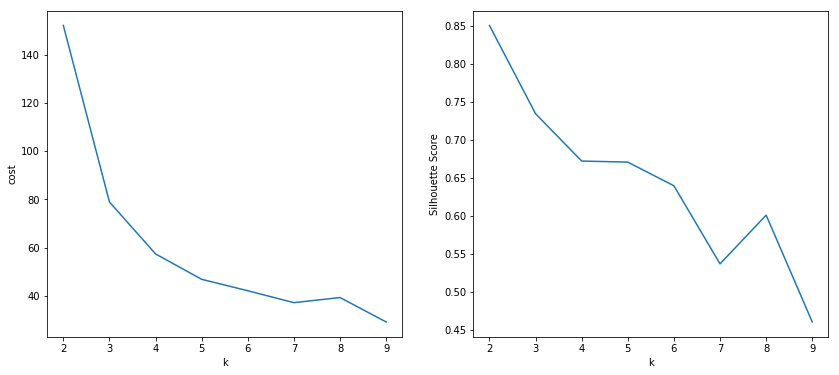

In [20]:
#Elbow method to determine the optimal number of clusters for k-means
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

max_cluster=10
cost = np.zeros(max_cluster)
silh_val=np.zeros(max_cluster)

for k in range(2,max_cluster):
    print("k=:",k)
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("cluster")

    kmodel = kmeans.fit(data)
    cost[k] = kmodel.computeCost(data) # requires Spark 2.0 or later
    
    # Make predictions
    kpredictions = kmodel.transform(data)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(predictionCol='cluster')
    silhouette = evaluator.evaluate(kpredictions)
    silh_val[k]=silhouette

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

fig, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6))
ax1.plot(range(2,max_cluster),cost[2:max_cluster])
ax1.set_xlabel('k')
ax1.set_ylabel('cost')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(range(2,max_cluster),silh_val[2:max_cluster])
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [26]:
# use K=3
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(3) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

kmodel = pipeline.fit(transformed)
kcluster = kmodel.transform(transformed)
kcluster.show(5)

+------------+-----------+------------+-----------+-------+-----------------+-----------------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|  indexedFeatures|cluster|
+------------+-----------+------------+-----------+-------+-----------------+-----------------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|      1|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|      1|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|      1|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|      1|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|      1|
+------------+-----------+------------+-----------+-------+-----------------+-----------------+-------+
only showing top 5 rows

